In [374]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Elasticsearch issues analysis
## Main objective
Investigate whether issues have been used consistently over time and throughout the release versions of the software, and is therefore a reliable source of information to use when validating our anomaly predictions.

## Data loading

### Labels

In [323]:
issues_labels = pd.read_csv("./issues_labels.csv", index_col=0, squeeze=True, header=None)

In [324]:
len(issues_labels)

438

### Labels and issues 

In [327]:
ilpr = pd.read_csv("issues_label_per_row.csv", index_col=0)
ilpr

,id,label
0,681010786,backport
1,681010786,v7.9.1
2,681010233,backport
3,681010233,v7.10.0
4,680841671,:ml
...,...,...
166760,1400233,:Distributed/Distributed
166761,1400233,>feature
166762,1400233,Team:Distributed
166763,1400233,high hanging fruit


In [279]:
ilac = pd.read_csv("issue_labels_as_columns.csv", index_col=0)
ilac

,:Analytics/Aggregations,:Analytics/Geo,:Analytics/Graph,:Analytics/Rollup,:Core/Features/CAT APIs,:Core/Features/Data streams,:Core/Features/Features,:Core/Features/ILM+SLM,:Core/Features/Indices APIs,:Core/Features/Ingest,...,v7.7.0,v7.7.1,v7.7.2,v7.8.0,v7.8.1,v7.8.2,v7.9.0,v7.9.1,v8.0.0,won't fix
id,,,,,,,,,,,,,,,,,,,,,
681010786,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
681010233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
680841671,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
680827130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
680805162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23083082,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20864348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20743479,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Tags

In [280]:
tags = pd.read_csv("./tags.csv", index_col=0)
tags.head()

,Tag,Sha
0,v7.9.0,a479a2a7fce0389512d6a9361301708b92dff667
1,v7.8.1,b5ca9c58fb664ca8bf9e4057fc229b3396bf3a89
2,v7.8.0,757314695644ea9a1dc2fecd26d1a43856725e65
3,v7.7.1,ad56dce891c901a492bb1ee393f12dfff473a423
4,v7.7.0,81a1e9eda8e6183f5237786246f6dced26a10eaf


In [350]:
len(tags)

280

### Tags and issues count

In [282]:
# format data
tic = []
for index, tag in tags.iterrows():
    tic.append((tag.Tag, len(ilpr[ilpr["label"]==tag.Tag].id.unique())))

In [283]:
# create a dataframe for easy manipulation
tagsIssueCountDf = pd.DataFrame(tic, columns=["Tag", "Issues"])
tagsIssueCountDf

## Statistical analysis
* Quantify the number of issues and the its statistics over tags (mean, median, outliers)

### Issues

In [352]:
len(ilac)

61103

We have in total 61103 issues

### Labels

In [355]:
len(issues_labels)

438

### Tags and issues

In [285]:
tagsIssueCountDf.describe()

,Issues
count,280.000000
mean,163.996429
std,478.836250
min,0.000000
25%,13.000000
50%,32.000000
75%,90.000000
max,5707.000000


The percentiles (75th is 90) are low compared to the mean (163). This indicates the presence of outliers which influence the mean. Indeed the max value is very high with 5707 and we have a large standard deviation.

Let's plot these in a box plot to confirm our intuition

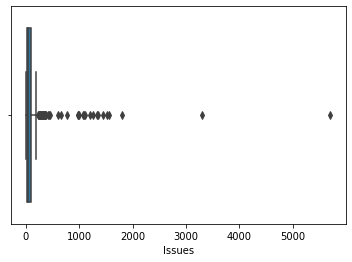

In [286]:
sns.boxplot(tagsIssueCountDf.Issues)

In [287]:
from matplotlib.cbook import boxplot_stats
outliers = [y for stat in boxplot_stats(tagsIssueCountDf.Issues) for y in stat['fliers']]
len(outliers)

45

The box plots confirms the presence of outlier. There are 45 of them. It means that there are 45 tags with many issues compared to most of the tags which have a mean around 163 and a median of 32. These could be possibly very defected releases. Among these v7.0.0-beta1 results the tag with most issues.

In [288]:
outliersDf = tagsIssueCountDf.sort_values(by="Issues", ascending=False).head(45)
outliersDf

,Tag,Issues
25,v7.0.0-beta1,5707
145,v2.0.0-beta1,3311
18,v7.2.0,1806
0,v7.9.0,1553
76,v6.0.0-alpha1,1525
120,v5.0.0-alpha1,1441
7,v7.6.0,1358
4,v7.7.0,1331
13,v7.4.0,1267
51,v6.5.0,1193


In [289]:
len(outliersDf[outliersDf.Tag.str.contains("alpha") |
               outliersDf.Tag.str.contains("rc") |
               outliersDf.Tag.str.contains("beta")]) / len(outliers)

0.26666666666666666

26% of the outliers are alpha/beta/rc versions. The rest are official releases.

**Observation** The number of issue per each tag is not evenly distributed. A high concentration of tags with fewer than 100 issues while 45 outliers exceed the value 200 going all the way to 5707. Only 26% of these outliers are not final releases (alpha beta and rc). while the rest are.
The number of issues for these tags may depend on 
* How buggy these releases were
* How popular these releases were

### Explore the distribution of issues throughout the different tags
* Is the number of issues evenly distributed over the tags (and therefore over time)?
* What are the most issue reported versions? Are they concentrated in some specific periods (old or recent releases)?

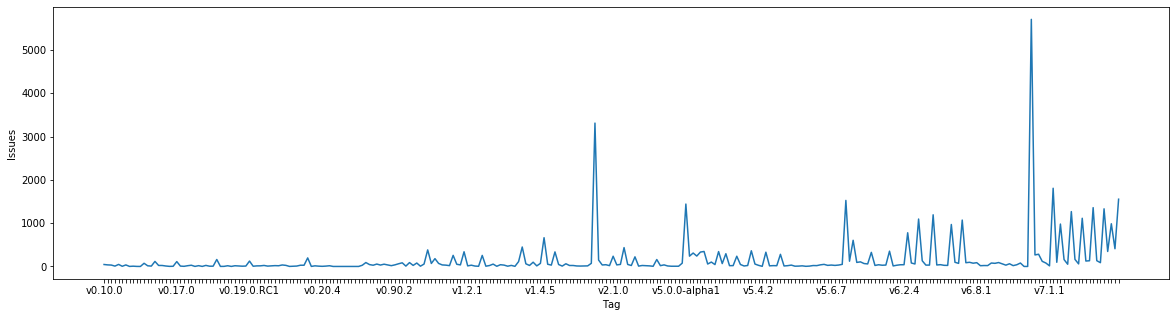

In [290]:
plt.figure(figsize=(20,5))
plt.locator_params(axis='x', nbins=6)
ax = sns.lineplot(x="Tag", y="Issues", data=tagsIssueCountDf.head(280))
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 20 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

Let's investigate the first peak around version v1.0.0 at what tag it belongs to.

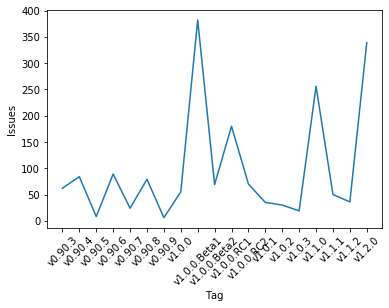

In [356]:
ax = sns.lineplot(x="Tag", y="Issues", data=tagsIssueCountDf[(tagsIssueCountDf.Tag < "v1.2.1") & (tagsIssueCountDf.Tag > "v0.90.2")])
ax.tick_params(axis='x', labelrotation= 45)

We can see that it indeed belongs to v1.0.0.

#### Comparison of below-v1 and above-v1

Let's compare the statistics of version below and above v1.0.0 to quantify the differences in number of issues
* Has there been a change in the use of the ITS from version 1 and above?

In [292]:
tagsIssueCountDf[(tagsIssueCountDf.Tag < "v1.0.0")].describe()

,Issues
count,88.000000
mean,26.306818
std,36.415974
min,0.000000
25%,4.000000
50%,14.000000
75%,32.000000
max,197.000000


In [293]:
tagsIssueCountDf[(tagsIssueCountDf.Tag >= "v1.0.0")].describe()

,Issues
count,192.000000
mean,227.104167
std,567.080832
min,0.000000
25%,21.000000
50%,49.000000
75%,159.250000
max,5707.000000


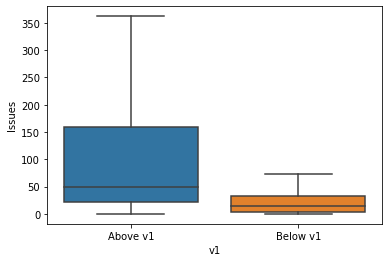

In [357]:
tagsv1 = pd.DataFrame(tagsIssueCountDf.Issues)
tagsv1["v1"] = tagsIssueCountDf.Tag.apply(lambda tag: "Below v1" if tag < "v1.0.0" else "Above v1")
# Some outliers from Above v1 have been removed for readibility
ax = sns.boxplot(x="v1", y="Issues", data=tagsv1, showfliers=False)

**Observation** By plotting the number of issues for each tag sorted in an ascending order, we notice that the versions up to roughly v1.0.0 have few issues compared to the versions coming after. Statistical summaries show that the mean of "below v1" is 26 whereas "above v1" is 227 which is even larger than the maximum value of "below v1". This shows an increasing trend of more issues with versions above v1.

In order to assess this impression, we need to plot statistics at a finer grain.

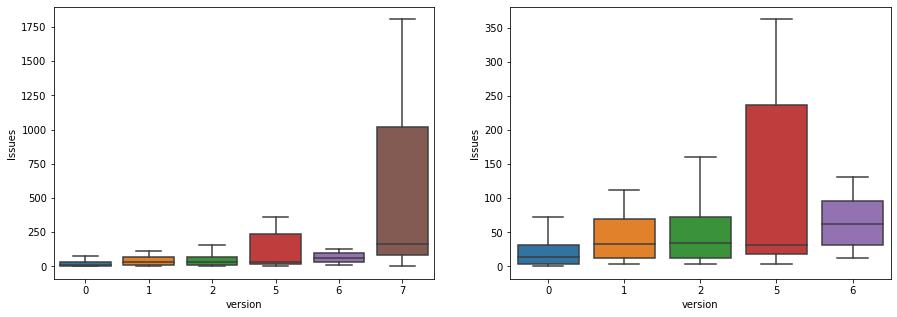

In [295]:
f, axes = plt.subplots(1,2, figsize=(15,5))
def version(tag):
    for i in range(8):
        if((tag > f"v{i}") & (tag < f"v{i+1}")):
            return i
tagsv = pd.DataFrame(tagsIssueCountDf.Issues)
tagsv["version"] = tagsIssueCountDf.Tag.apply(version)
ax = sns.boxplot(ax=axes[0], x="version", y="Issues", data=tagsv, showfliers = False)
ax = sns.boxplot(ax=axes[1], x="version", y="Issues", data=tagsv[tagsv.version <7], showfliers = False)

***Observations***
-  Given the high number of tags, we had to group them in a meaningful way. We believe that major versions is a good compromise as it preserves the temporal trend and as that is what we are interested in: verify if the ITS has been used consistently over time.
- Our first observation turned out to be biased by versions 6 and 7 which do have significantly more issues and were therefore contributing in altering the "abvove v1" statistics. When we plot boxplots for tags grouped by each major version, we see that the v0 one does not differ much from the ones of v1 and v2. It is slightly lower in median and percentiles.

This could be due to different reasons:

* Versions below v1.0.0 were not widely adopted and therefore received fewer issues from users
* Elasticsearch was not extensively using Github ITS as their main ITS
* Those versions presented indeed fewer issues, possibly due to the fewer features implemented

**Conclusions**
* Elasticsearch seems to have used the ITS consistently over time and through the different versions. There has been a slightly increase over time and version 7 presents many more issues than ever before. This is probably due to either more bugs or major features implemented, as well as more popularity obtained by the project.


**Other observations**
- Elasticsearch has jumped from major version 2 to version 5 skipping 3 and 4

In [358]:
versions = [0,1,2,5,6,7]

### Issue type distribution
* Do some versions present more issues of a specific type?

#### Labels for versions with no tag

List labels which do not correspond to a Tag

In [297]:
len(issues_labels[~issues_labels.isin(tags.Tag)])

169

Of these labels, list the ones which do not have a tag associated

In [298]:
no_tag_version_labels = issues_labels[(~issues_labels.isin(tags.Tag)) & (issues_labels.str.startswith("v"))]
len(no_tag_version_labels)

49

Count how many issues are labelled with these labels

In [299]:
len(ilpr[ilpr.label.isin(no_tag_version_labels.values)])

25876

In [300]:
issue_indexes = ilpr[ilpr.label.isin(no_tag_version_labels.values)].id.unique().tolist()

These labels seem to be associated with internal versions which did not end up getting tagged and released.
How many of these issues are associated only with this label as version? Issues may be labelled with more versions

We first select only the interested issues. We then filter out all the labels not being versions and remove the ones not associated with tags. We are left with the count of labels associated with these issues which are tags. All of them have more than 2 of these.

In [387]:
#issues associated also with valid tag labels
with_valid_tag = ilpr[ilpr.id.isin(issue_indexes) & 
    ilpr.label.str.startswith("v") & 
    ~ilpr.label.isin(no_tag_version_labels)].id.unique().tolist()

In [388]:
1 - len(set(issue_indexes)^set(with_valid_tag)) / len(ilpr[ilpr.label.isin(no_tag_version_labels.values)])

0.7879115782964909

**Observations**
* Some of the labels representing versions (following the vX.Y.Z convention) do not have a corrisponding tag
* The 78% of these issues labeled with these version-label are also associated with a valid tag label
* The rest of these issues may have been present in some versions which did not end up being tagged as releases. This should not represent a problem in our analysis

## Type of labels
We were not able to find documentation for the type and convention for issue labels.
By exploring the labels however, we identified some patterns which may help us focus our analysis.

* **Sw versions** Labels representing specific sw versions have the format "vX.Y.Z"
* **Major categories** These labels start with the sign ">"
* **Specific topics** Thes labels start with the sign ":"

We believe there is a hierarchy in labelling issues as follows: Major category -> topic

### Topics

In [389]:
topic_labels = issues_labels[(issues_labels.str.startswith(":"))]
topic_labels.unique()

array([':Analytics/Aggregations', ':Analytics/Geo', ':Analytics/Graph',
       ':Analytics/Rollup', ':Core/Features/CAT APIs',
       ':Core/Features/Data streams', ':Core/Features/Features',
       ':Core/Features/ILM+SLM', ':Core/Features/Indices APIs',
       ':Core/Features/Ingest',
       ':Core/Features/Java High Level REST Client',
       ':Core/Features/Java Low Level REST Client',
       ':Core/Features/Monitoring', ':Core/Features/Stats',
       ':Core/Features/Watcher', ':Core/Infra/Build',
       ':Core/Infra/Circuit Breakers', ':Core/Infra/Core',
       ':Core/Infra/Logging', ':Core/Infra/Packaging',
       ':Core/Infra/Plugins', ':Core/Infra/REST API',
       ':Core/Infra/Resiliency', ':Core/Infra/Scripting',
       ':Core/Infra/Settings', ':Core/Infra/Transport API',
       ':Distributed/Allocation', ':Distributed/Autoscaling',
       ':Distributed/CCR', ':Distributed/CRUD',
       ':Distributed/Cluster Coordination',
       ':Distributed/Discovery-Plugins', ':Distribute

### Categories

In [303]:
category_labels = issues_labels[(issues_labels.str.startswith(">"))]
category_labels.unique()

array(['>breaking', '>breaking-java', '>bug', '>deprecation', '>docs',
       '>enhancement', '>feature', '>non-issue', '>refactoring',
       '>regression', '>test', '>test-failure', '>test-mute', '>upgrade'],
      dtype=object)

### All labels which do not represent versions

In [304]:
labels_no_version = issues_labels[~(issues_labels.str.startswith("v"))]
labels_no_version.describe()

count                      120
unique                     120
top       :Query Languages/EQL
freq                         1
Name: 1, dtype: object

### Labels which are neither tags, topics or categories

In [310]:
left_out_labels = issues_labels[~(issues_labels.str.startswith("v")) &
                               ~(issues_labels.isin(category_labels)) &
                               ~(issues_labels.isin(topic_labels))]
left_out_labels

0
75                Awaiting CLA
76         Dependency:Endpoint
77             Dependency:SIEM
78                        Meta
79                        PITA
80             Pioneer Program
81     Pretty Bloody Important
82              Team:Analytics
83                Team:Clients
84          Team:Core/Features
85             Team:Core/Infra
86            Team:Distributed
87                   Team:Docs
88                     Team:ML
89            Team:Performance
90                     Team:QL
91                 Team:Search
92               Team:Security
93                     Team:UI
94                     Top Ask
95                         WIP
96                [>test-mute]
97                    backport
98            backport pending
99                     blocker
100                   critical
101                das awesome
102                    discuss
103          experimental/beta
104            feedback_needed
105           good first issue
106                help wanted
107   

### Quantify overlapping of the same label groups

In [344]:
(ilpr[ilpr.label.isin(category_labels)].groupby("id").count() > 1).sum() / len(ilpr.id.unique())

label    0.039191
dtype: float64

In [338]:
(ilpr[ilpr.label.isin(topic_labels)].groupby("id").count() > 1).sum() / len(ilpr.id.unique())

label    0.029571
dtype: float64

Indeed only the 3% and 4% have two labels of the same group

**Observations**
* Our intuition regarding the convention for labels seems to hold
* The labels "left out" from the convention indeed seem to be internal labels, used to assign issues to some specific teams (Team:) or specify even further the specific issue type (jdk)
* We quantified how many issues have more than one label of the same group and this resulted in a very low number (3% and 4%). The overlapping is of course allowed and in some cases needed, but this low number confirms our intuition on the convention since in 97% of the cases only one label per group is used
* Given the high number of labels and the low overlap of the ones in the same group, it seems to make sense to analyze these macro groups separately

## Issues distributions

### Category distributions

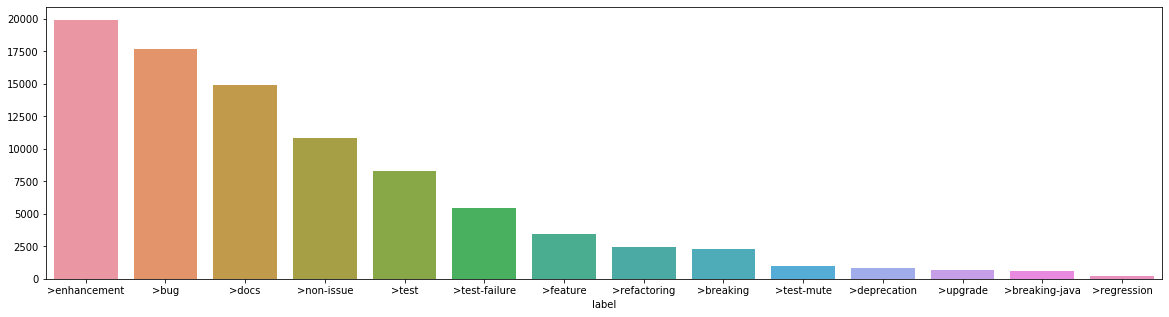

In [306]:
plt.figure(figsize=(20,5))
cat_count = ilpr[ilpr.label.isin(category_labels)].groupby("label").id.count().sort_values(ascending=False)
ax = sns.barplot(x=cat_count.index, y=cat_count.values)

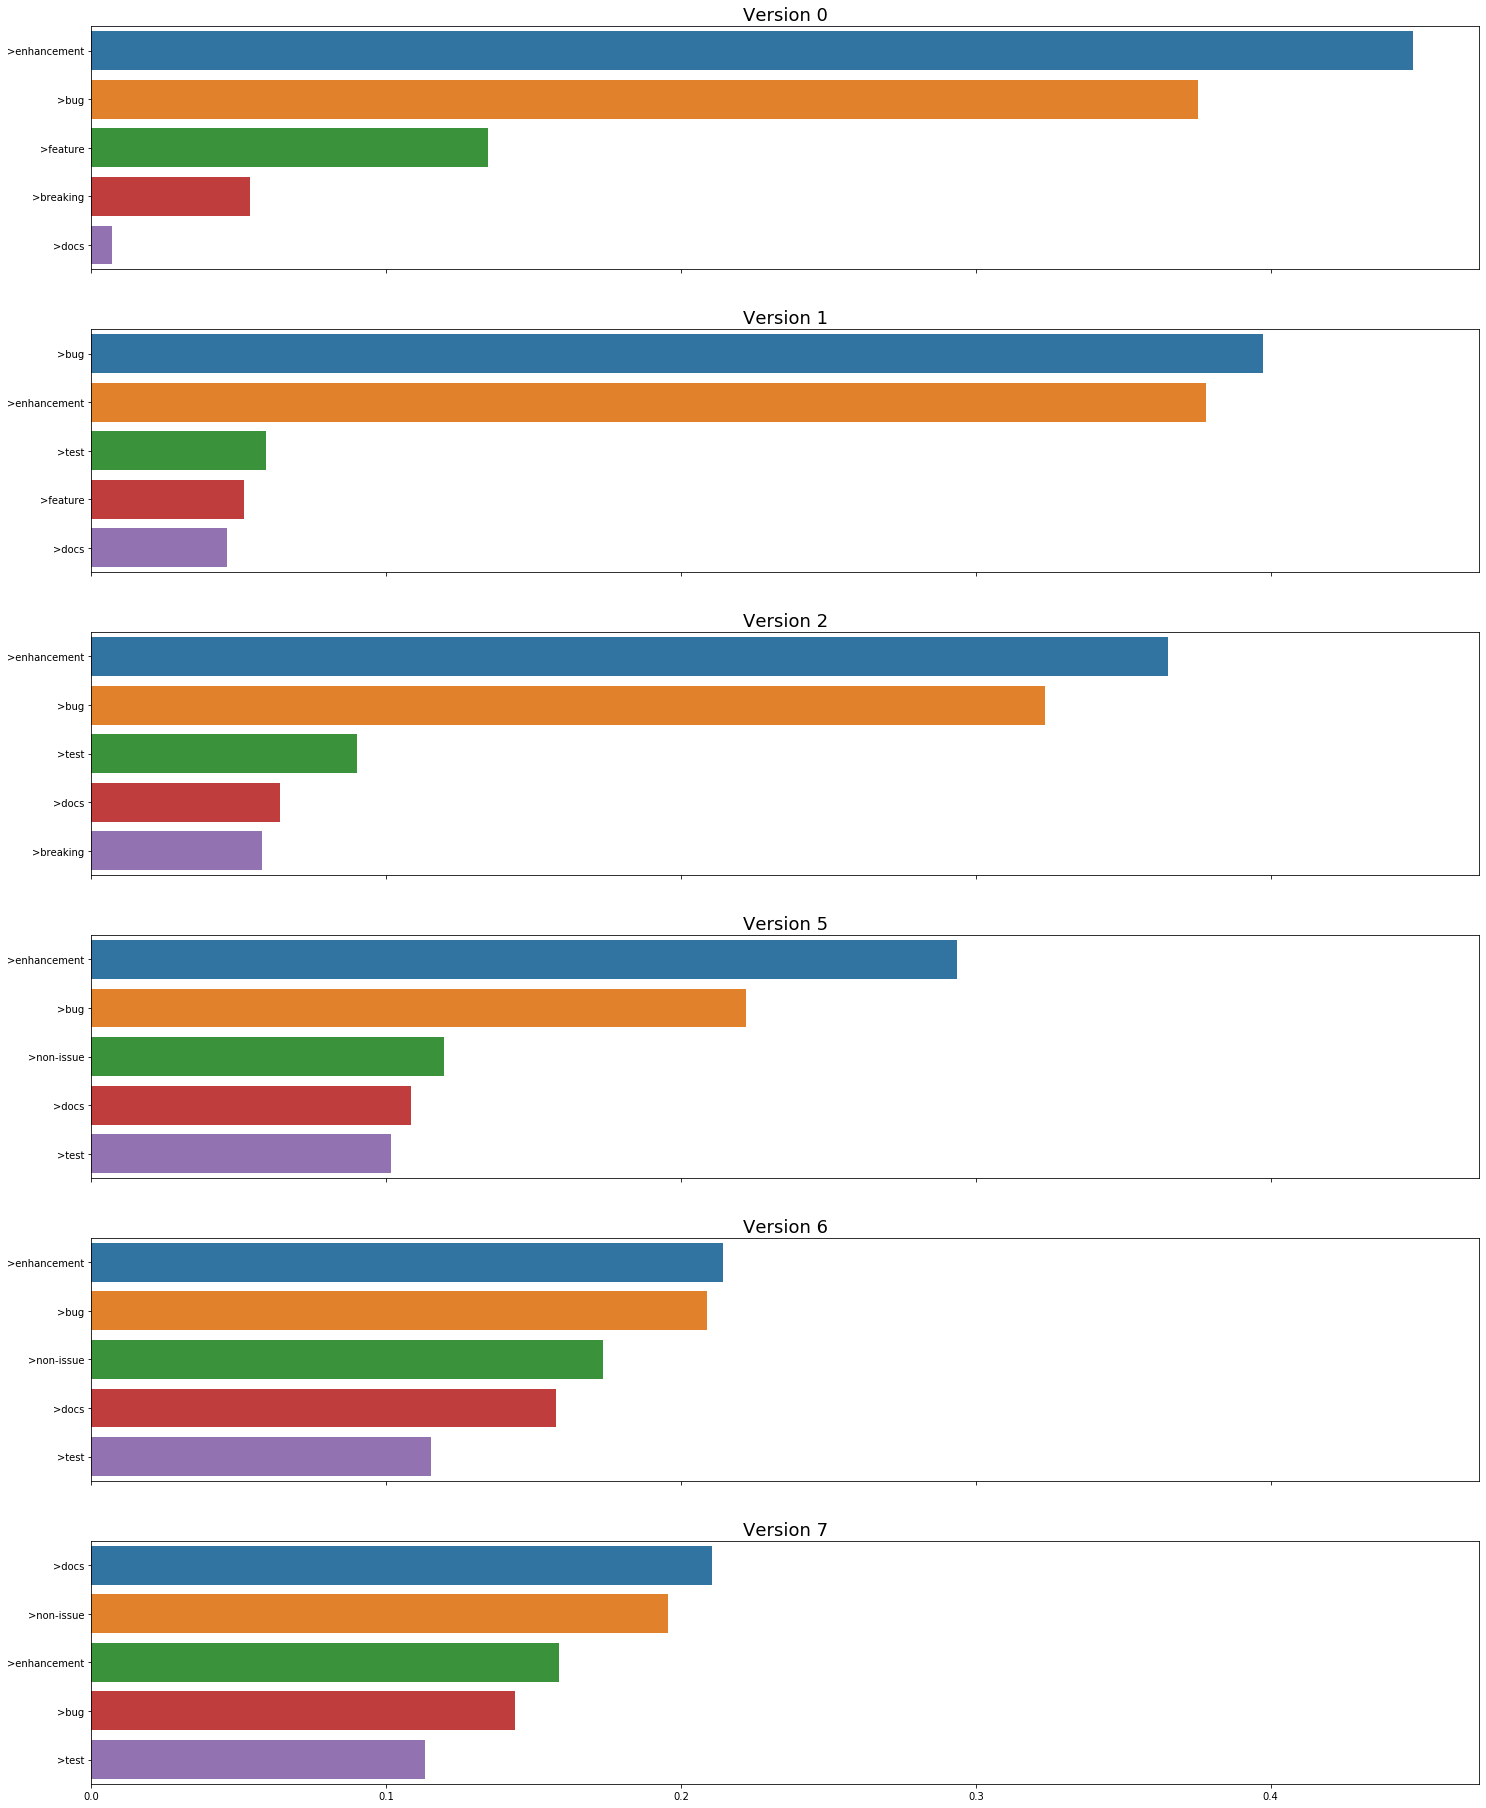

In [346]:
head = 5
fig, axes = plt.subplots(len(versions), figsize=(20,25), sharex='col')
fig.tight_layout(h_pad=5.0)
for i in range(len(versions)):
    issues_for_version = ilpr[ilpr.label.str.startswith(f"v{versions[i]}")].id.unique()
    issues_type_for_version = (ilpr[ilpr.id.isin(issues_for_version) & 
                               ilpr.label.isin(category_labels)].groupby("label").id.count() / len(issues_for_version)).sort_values(ascending=False)
    ax = sns.barplot(ax=axes[i], y=issues_type_for_version.head(head).index.tolist(),
                     x=issues_type_for_version.head(head).values)
    #ax.tick_params(axis='x', labelrotation= 45)
    ax.set_title(f"Version {versions[i]}", fontdict={'fontsize': 18, 'fontweight': 'medium'})

**Observations**
* enhancement, bug and docs have been the most prevalent labels in this group
* enhancement and bug have been by far the most used labels in this group 
* Over time this has slowly decreased to a point where in version 7 bug is only the 4th most used label

### Topics distribution

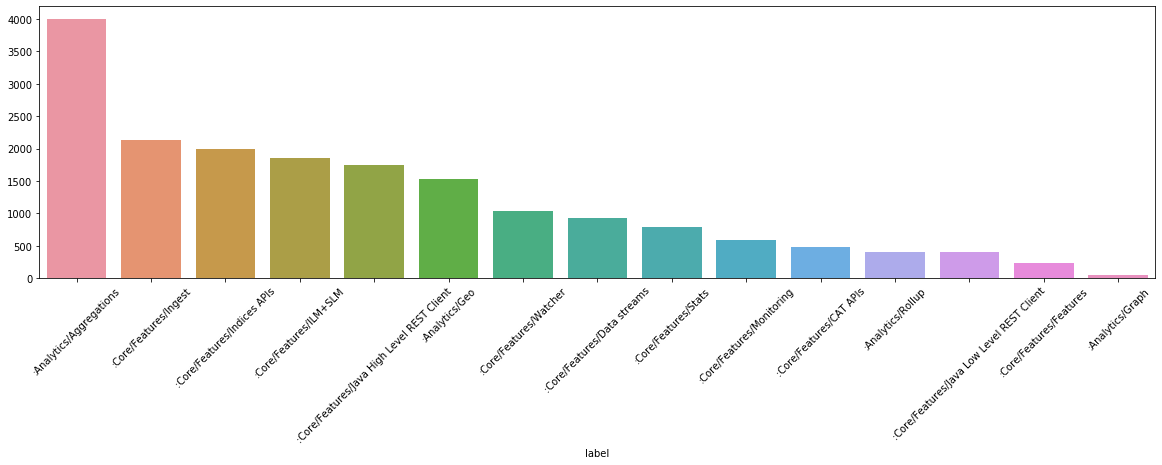

In [308]:
plt.figure(figsize=(20,5))
cat_count = ilpr[ilpr.label.isin(topic_labels)].groupby("label").id.count().head(15).sort_values(ascending=False)
ax = sns.barplot(x=cat_count.index, y=cat_count.values)
ax.tick_params(axis='x', labelrotation= 45)

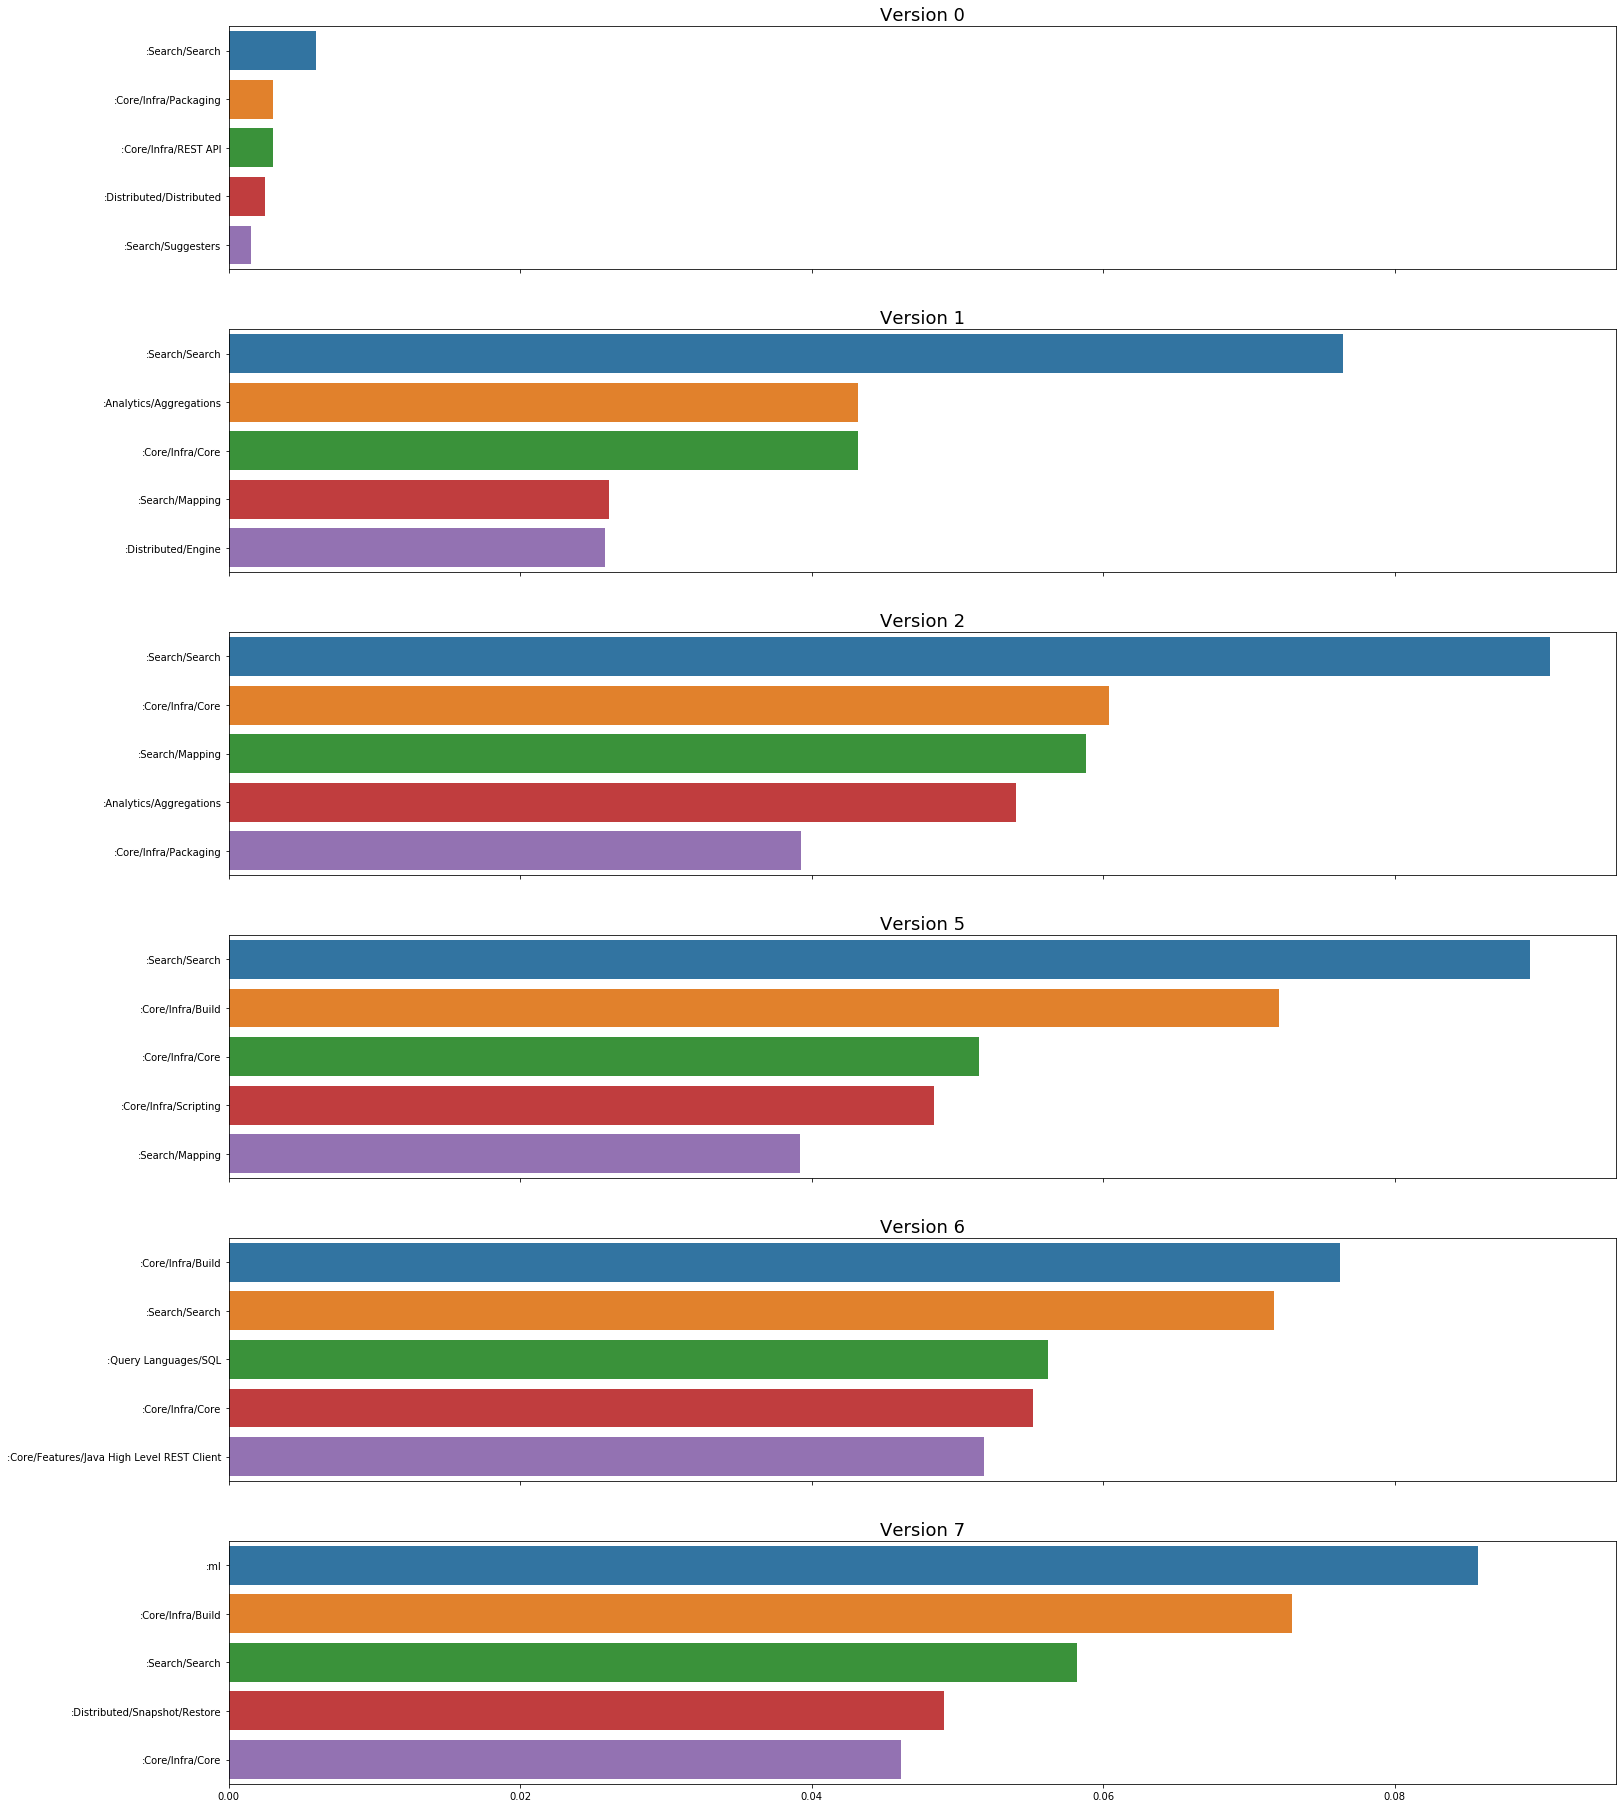

In [349]:
head = 5
fig, axes = plt.subplots(len(versions), figsize=(20,25), sharex='col')
fig.tight_layout(h_pad=5.0)
for i in range(len(versions)):
    issues_for_version = ilpr[ilpr.label.str.startswith(f"v{versions[i]}")].id.unique()
    issues_type_for_version = (ilpr[ilpr.id.isin(issues_for_version) & 
                               ilpr.label.isin(topic_labels)].groupby("label").id.count() / len(issues_for_version)).sort_values(ascending=False)
    ax = sns.barplot(ax=axes[i], y=issues_type_for_version.head(head).index.tolist(),
                     x=issues_type_for_version.head(head).values)
    #ax.tick_params(axis='x', labelrotation= 45)
    ax.set_title(f"Version {versions[i]}", fontdict={'fontsize': 18, 'fontweight': 'medium'})

**Observations**
* Analytics/Aggregation is by far the most popular label in the topic group over all issues
* Version 0 did not present many issues labeled with topic labels
* From version 1 we see a more extensive use of topic labels
* Search/Search is in the top labels for all versions. This does not surprise given the nature of elasticsearch
* Machine learning has gained popularity and we can see that it is the top label for the most recent version whereas it was not present in the top labels of the previous versions
* The opposite has happened for Analytics/Aggregation which has slowly lost popularity since version 5

### ToDo

* Plot distribution of issue types in general
* Does the number increase over time? (more in last releases? Sign of bias)
* Is there a trend in the types of issues that has become more popular?